In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/testing-dataset/Test/No_Fire/resized_test_nofire_frame3316.jpg
/kaggle/input/testing-dataset/Test/No_Fire/resized_test_nofire_frame44.jpg
/kaggle/input/testing-dataset/Test/No_Fire/resized_test_nofire_frame2324.jpg
/kaggle/input/testing-dataset/Test/No_Fire/resized_test_nofire_frame2020.jpg
/kaggle/input/testing-dataset/Test/No_Fire/resized_test_nofire_frame1062.jpg
/kaggle/input/testing-dataset/Test/No_Fire/resized_test_nofire_frame1753.jpg
/kaggle/input/testing-dataset/Test/No_Fire/resized_test_nofire_frame3244.jpg
/kaggle/input/testing-dataset/Test/No_Fire/resized_test_nofire_frame659.jpg
/kaggle/input/testing-dataset/Test/No_Fire/resized_test_nofire_frame3125.jpg
/kaggle/input/testing-dataset/Test/No_Fire/resized_test_nofire_frame3071.jpg
/kaggle/input/testing-dataset/Test/No_Fire/resized_test_nofire_frame736.jpg
/kaggle/input/testing-dataset/Test/No_Fire/resized_test_nofire_frame3212.jpg
/kaggle/input/testing-dataset/Test/No_Fire/resized_test_nofire_frame2294.jpg
/ka

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR

from torchvision import transforms, datasets
from transformers import SwinForImageClassification

from sklearn.metrics import (
    roc_curve,
    auc,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
from tqdm import tqdm
from collections import Counter


In [25]:
def log_gpu_usage():
    """Logs GPU memory usage."""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024**9)  # Convert to GB
        reserved = torch.cuda.memory_reserved() / (1024**9)  # Convert to GB
        print(f"GPU Memory Allocated: {allocated:.2f} GB")
        print(f"GPU Memory Reserved: {reserved:.2f} GB")
    else:
        print("GPU is not available.")


In [7]:
train_data_path = '/kaggle/input/training-swin/Training'
test_data_path = '/kaggle/input/testing-dataset/Test'


In [8]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [9]:
# Load dataset
full_dataset = datasets.ImageFolder(root=train_data_path, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=test_transforms)

# Balance dataset
targets = np.array([sample[1] for sample in full_dataset.samples])
class_counts = Counter(targets)
min_class_count = min(class_counts.values())

# Subsample to balance
balanced_indices = []
for class_label in class_counts:
    indices = np.where(targets == class_label)[0]
    balanced_indices.extend(np.random.choice(indices, min_class_count, replace=False))

balanced_subset = Subset(full_dataset, balanced_indices)

# Train-validation split
train_indices, val_indices = train_test_split(
    range(len(balanced_subset)),
    test_size=0.2,
    stratify=[balanced_subset[i][1] for i in range(len(balanced_subset))],
    random_state=42
)

train_subset = Subset(balanced_subset, train_indices)
val_subset = Subset(balanced_subset, val_indices)
val_subset.dataset.transform = test_transforms

# Data loaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Balanced Training Set Size: {len(train_subset)}")
print(f"Balanced Validation Set Size: {len(val_subset)}")
print(f"Test Set Size: {len(test_dataset)}")


Balanced Training Set Size: 22971
Balanced Validation Set Size: 5743
Test Set Size: 8617


In [10]:
# Load pre-trained Swin Transformer
swin_model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224", 
    num_labels=2, 
    ignore_mismatched_sizes=True
)

# Update classifier
swin_model.classifier = nn.Linear(swin_model.classifier.in_features, 2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
swin_model = swin_model.to(device)


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(swin_model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

In [13]:
def train_model(
    model, train_loader, val_loader, optimizer, scheduler, criterion,
    num_epochs=50, patience=5, min_delta=0.001, device='cuda'
):
    model.to(device)
    best_accuracy = 0.0
    epochs_without_improvement = 0
    gpu_memory_log = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']}")
        log_gpu_usage()

        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc="Training Batches"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images).logits
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_accuracy = 100. * correct / total
        print(f"Train Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

        # Record GPU memory usage
        gpu_memory_log.append(torch.cuda.memory_allocated() / (1024**3))

        # Early stopping logic
        if train_accuracy - best_accuracy > min_delta:
            best_accuracy = train_accuracy
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Training stopped early at epoch {epoch+1} with accuracy: {best_accuracy:.2f}%")
            break

        scheduler.step()

    return gpu_memory_log


In [19]:
gpu_memory_log = train_model(
    model=swin_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    num_epochs=50,
    patience=5,
    min_delta=0.001,
    device='cuda'
)



Epoch 1/50
Learning Rate: 0.0001
GPU Memory Allocated: 0.44 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:50<00:00,  2.05it/s]


Train Loss: 0.0146, Train Accuracy: 99.54%

Epoch 2/50
Learning Rate: 0.0001
GPU Memory Allocated: 0.45 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:50<00:00,  2.05it/s]


Train Loss: 0.0103, Train Accuracy: 99.70%

Epoch 3/50
Learning Rate: 0.0001
GPU Memory Allocated: 0.45 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:49<00:00,  2.06it/s]


Train Loss: 0.0080, Train Accuracy: 99.77%

Epoch 4/50
Learning Rate: 0.0001
GPU Memory Allocated: 0.45 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:49<00:00,  2.06it/s]


Train Loss: 0.0131, Train Accuracy: 99.60%

Epoch 5/50
Learning Rate: 5e-05
GPU Memory Allocated: 0.45 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:50<00:00,  2.05it/s]


Train Loss: 0.0062, Train Accuracy: 99.83%

Epoch 6/50
Learning Rate: 5e-05
GPU Memory Allocated: 0.45 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:49<00:00,  2.05it/s]


Train Loss: 0.0036, Train Accuracy: 99.88%

Epoch 7/50
Learning Rate: 5e-05
GPU Memory Allocated: 0.45 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:49<00:00,  2.05it/s]


Train Loss: 0.0042, Train Accuracy: 99.86%

Epoch 8/50
Learning Rate: 5e-05
GPU Memory Allocated: 0.45 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:49<00:00,  2.06it/s]


Train Loss: 0.0032, Train Accuracy: 99.90%

Epoch 9/50
Learning Rate: 5e-05
GPU Memory Allocated: 0.45 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:48<00:00,  2.06it/s]


Train Loss: 0.0061, Train Accuracy: 99.86%

Epoch 10/50
Learning Rate: 2.5e-05
GPU Memory Allocated: 0.45 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:49<00:00,  2.05it/s]


Train Loss: 0.0032, Train Accuracy: 99.91%

Epoch 11/50
Learning Rate: 2.5e-05
GPU Memory Allocated: 0.45 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:49<00:00,  2.05it/s]


Train Loss: 0.0026, Train Accuracy: 99.93%

Epoch 12/50
Learning Rate: 2.5e-05
GPU Memory Allocated: 0.45 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:49<00:00,  2.05it/s]


Train Loss: 0.0029, Train Accuracy: 99.92%

Epoch 13/50
Learning Rate: 2.5e-05
GPU Memory Allocated: 0.45 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:49<00:00,  2.05it/s]


Train Loss: 0.0022, Train Accuracy: 99.96%

Epoch 14/50
Learning Rate: 2.5e-05
GPU Memory Allocated: 0.45 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:50<00:00,  2.05it/s]


Train Loss: 0.0023, Train Accuracy: 99.90%

Epoch 15/50
Learning Rate: 1.25e-05
GPU Memory Allocated: 0.45 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:49<00:00,  2.05it/s]


Train Loss: 0.0026, Train Accuracy: 99.92%

Epoch 16/50
Learning Rate: 1.25e-05
GPU Memory Allocated: 0.45 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:49<00:00,  2.05it/s]


Train Loss: 0.0018, Train Accuracy: 99.95%

Epoch 17/50
Learning Rate: 1.25e-05
GPU Memory Allocated: 0.45 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:49<00:00,  2.06it/s]


Train Loss: 0.0016, Train Accuracy: 99.96%

Epoch 18/50
Learning Rate: 1.25e-05
GPU Memory Allocated: 0.45 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:49<00:00,  2.05it/s]


Train Loss: 0.0014, Train Accuracy: 99.97%

Epoch 19/50
Learning Rate: 1.25e-05
GPU Memory Allocated: 0.45 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:49<00:00,  2.06it/s]


Train Loss: 0.0016, Train Accuracy: 99.95%

Epoch 20/50
Learning Rate: 6.25e-06
GPU Memory Allocated: 0.45 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:49<00:00,  2.05it/s]


Train Loss: 0.0013, Train Accuracy: 99.95%

Epoch 21/50
Learning Rate: 6.25e-06
GPU Memory Allocated: 0.45 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:49<00:00,  2.05it/s]


Train Loss: 0.0012, Train Accuracy: 99.95%

Epoch 22/50
Learning Rate: 6.25e-06
GPU Memory Allocated: 0.45 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:49<00:00,  2.06it/s]


Train Loss: 0.0011, Train Accuracy: 99.96%

Epoch 23/50
Learning Rate: 6.25e-06
GPU Memory Allocated: 0.45 GB
GPU Memory Reserved: 3.86 GB


Training Batches: 100%|██████████| 718/718 [05:49<00:00,  2.06it/s]

Train Loss: 0.0013, Train Accuracy: 99.96%
Training stopped early at epoch 23 with accuracy: 99.97%


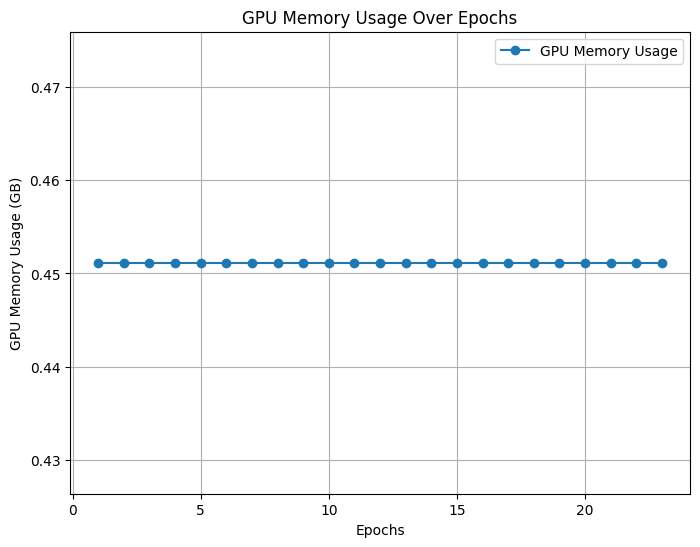

In [27]:
# Plot GPU memory usage
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(gpu_memory_log) + 1), gpu_memory_log, marker='o', label="GPU Memory Usage")
plt.xlabel("Epochs")
plt.ylabel("GPU Memory Usage (GB)")
plt.title("GPU Memory Usage Over Epochs")
plt.legend()
plt.grid()
plt.show()

In [31]:
import torch.nn.functional as F  # Add this import

def evaluate_model_with_metrics(model, loader, binary_classification=True):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  # For AUC-ROC

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images).logits
            
            # Predicted class
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Probabilities for AUC-ROC
            if binary_classification:
                probabilities = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
                all_probs.extend(probabilities)

    # Accuracy
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
    print(f"Accuracy: {accuracy:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels),
                yticklabels=np.unique(all_labels), cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Precision, Recall, F1-Score
    precision = precision_score(all_labels, all_preds, average='binary' if binary_classification else 'weighted')
    recall = recall_score(all_labels, all_preds, average='binary' if binary_classification else 'weighted')
    f1 = f1_score(all_labels, all_preds, average='binary' if binary_classification else 'weighted')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # AUC-ROC and ROC Curve (for binary classification)
    if binary_classification:
        all_probs = np.array(all_probs)
        if len(np.unique(all_labels)) == 2: 
            fpr, tpr, _ = roc_curve(all_labels, all_probs)
            auc_score = auc(fpr, tpr)
            print(f"AUC-ROC: {auc_score:.4f}")

            # Plot ROC Curve
            plt.figure()
            plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
            plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc="lower right")
            plt.grid()
            plt.show()
        else:
            print("AUC-ROC is not supported for multi-class tasks without modification.")


Accuracy: 82.09%
Confusion Matrix:
 [[4823  314]
 [1229 2251]]


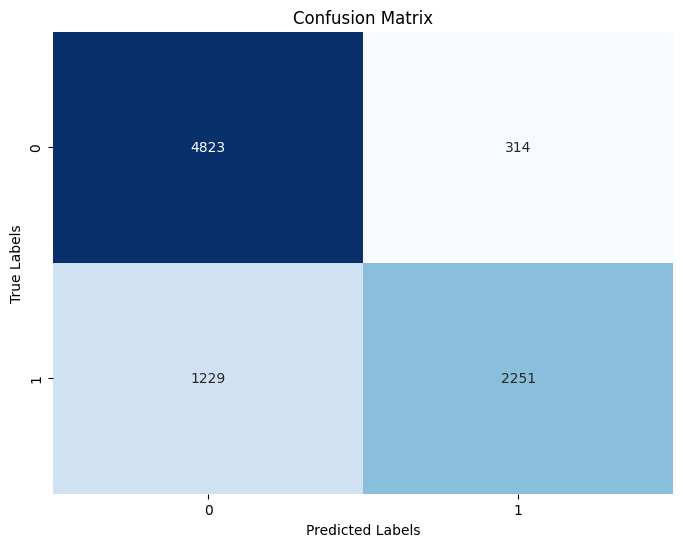

Precision: 0.8776
Recall: 0.6468
F1-Score: 0.7447
AUC-ROC: 0.9396


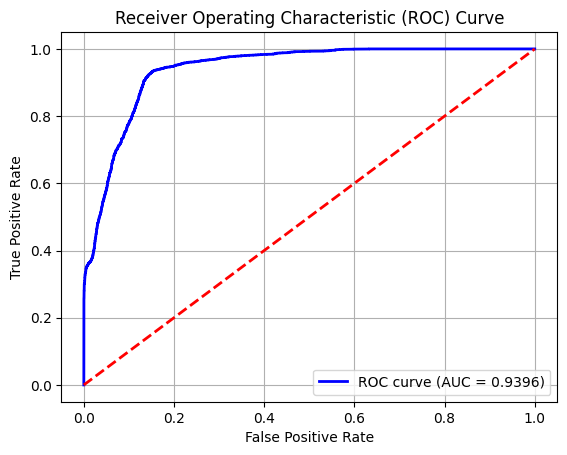

In [32]:
evaluate_model_with_metrics(swin_model, test_loader, binary_classification=True)
